# Heart Failure Dataset

Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worlwide.
Heart failure is a common event caused by CVDs and this dataset contains 12 features that can be used to predict mortality by heart failure.

Description :

+ `age`: Age
+ `anaemia`: Decrease of red blood cells or hemoglobin (boolean)
+ `creatinine_phosphokinase`: Level of the CPK enzyme in the blood (mcg/L)
+ `diabetes`: If the patient has diabetes (boolean)
+ `ejection_fraction`: Percentage of blood leaving the heart at each contraction (percentage)
+ `high_blood_pressure`: If the patient has hypertension (boolean)
+ `platelets`: Platelets in the blood (kiloplatelets/mL)
+ `serum_creatinine`: Level of serum creatinine in the blood (mg/dL)
+ `serum_sodium`: Level of serum sodium in the blood (mEq/L)
+ `sex`: Woman or man (binary)
+ `smoking`: smoking (binary)
+ `time` :
+ `DEATH_EVENT`: death (binary, target variable)

In [1]:
import findspark
findspark.init()
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import FloatType, IntegerType
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [2]:
spark = (SparkSession.builder 
         .master("local") 
         .appName("Heart Failure App") 
         .getOrCreate())

sc = spark.sparkContext

## Data exploration

In [3]:
data = spark.read.csv('heart_failure.csv', header=True)
data.printSchema()

root
 |-- age: string (nullable = true)
 |-- anaemia: string (nullable = true)
 |-- creatinine_phosphokinase: string (nullable = true)
 |-- diabetes: string (nullable = true)
 |-- ejection_fraction: string (nullable = true)
 |-- high_blood_pressure: string (nullable = true)
 |-- platelets: string (nullable = true)
 |-- serum_creatinine: string (nullable = true)
 |-- serum_sodium: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- smoking: string (nullable = true)
 |-- time: string (nullable = true)
 |-- DEATH_EVENT: string (nullable = true)



In [4]:
data.take(5)

[Row(age='75', anaemia='0', creatinine_phosphokinase='582', diabetes='0', ejection_fraction='20', high_blood_pressure='1', platelets='265000', serum_creatinine='1.9', serum_sodium='130', sex='1', smoking='0', time='4', DEATH_EVENT='1'),
 Row(age='55', anaemia='0', creatinine_phosphokinase='7861', diabetes='0', ejection_fraction='38', high_blood_pressure='0', platelets='263358.03', serum_creatinine='1.1', serum_sodium='136', sex='1', smoking='0', time='6', DEATH_EVENT='1'),
 Row(age='65', anaemia='0', creatinine_phosphokinase='146', diabetes='0', ejection_fraction='20', high_blood_pressure='0', platelets='162000', serum_creatinine='1.3', serum_sodium='129', sex='1', smoking='1', time='7', DEATH_EVENT='1'),
 Row(age='50', anaemia='1', creatinine_phosphokinase='111', diabetes='0', ejection_fraction='20', high_blood_pressure='0', platelets='210000', serum_creatinine='1.9', serum_sodium='137', sex='1', smoking='0', time='7', DEATH_EVENT='1'),
 Row(age='65', anaemia='1', creatinine_phosphoki

In [5]:
data.count()

299

In [6]:
data.rdd.getNumPartitions()

1

In [7]:
pd_data = data.limit(5).toPandas()
pd_data

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75,0,582,0,20,1,265000,1.9,130,1,0,4,1
1,55,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65,0,146,0,20,0,162000,1.3,129,1,1,7,1
3,50,1,111,0,20,0,210000,1.9,137,1,0,7,1
4,65,1,160,1,20,0,327000,2.7,116,0,0,8,1


In [8]:
data = (data
        .withColumn('age', data['age'].cast(FloatType()))
        .withColumn('anaemia', data['anaemia'].cast(IntegerType()))
        .withColumn('creatinine_phosphokinase', data['creatinine_phosphokinase'].cast(FloatType()))
        .withColumn('diabetes', data['diabetes'].cast(IntegerType()))
        .withColumn('ejection_fraction', data['ejection_fraction'].cast(FloatType()))
        .withColumn('high_blood_pressure', data['high_blood_pressure'].cast(IntegerType()))
        .withColumn('platelets', data['platelets'].cast(FloatType()))
        .withColumn('serum_creatinine', data['serum_creatinine'].cast(FloatType()))
        .withColumn('serum_sodium', data['serum_sodium'].cast(FloatType()))
        .withColumn('sex', data['sex'].cast(IntegerType()))
        .withColumn('smoking', data['smoking'].cast(IntegerType()))
        .withColumn('time', data['time'].cast(FloatType()))
        .withColumn('DEATH_EVENT', data['DEATH_EVENT'].cast(IntegerType()))
       )

In [9]:
data.printSchema()

root
 |-- age: float (nullable = true)
 |-- anaemia: integer (nullable = true)
 |-- creatinine_phosphokinase: float (nullable = true)
 |-- diabetes: integer (nullable = true)
 |-- ejection_fraction: float (nullable = true)
 |-- high_blood_pressure: integer (nullable = true)
 |-- platelets: float (nullable = true)
 |-- serum_creatinine: float (nullable = true)
 |-- serum_sodium: float (nullable = true)
 |-- sex: integer (nullable = true)
 |-- smoking: integer (nullable = true)
 |-- time: float (nullable = true)
 |-- DEATH_EVENT: integer (nullable = true)



In [10]:
def show_na(df):
    missing_count = []

    for column_name in df.columns:
        rows_with_missing = df.where(F.col(column_name).isNull())
        missing_count.append(rows_with_missing.count())

    return dict(zip(df.columns, missing_count))

In [11]:
show_na(data)

{'age': 0,
 'anaemia': 0,
 'creatinine_phosphokinase': 0,
 'diabetes': 0,
 'ejection_fraction': 0,
 'high_blood_pressure': 0,
 'platelets': 0,
 'serum_creatinine': 0,
 'serum_sodium': 0,
 'sex': 0,
 'smoking': 0,
 'time': 0,
 'DEATH_EVENT': 0}

no missing values

In [12]:
data.show(5, False)

+----+-------+------------------------+--------+-----------------+-------------------+---------+----------------+------------+---+-------+----+-----------+
|age |anaemia|creatinine_phosphokinase|diabetes|ejection_fraction|high_blood_pressure|platelets|serum_creatinine|serum_sodium|sex|smoking|time|DEATH_EVENT|
+----+-------+------------------------+--------+-----------------+-------------------+---------+----------------+------------+---+-------+----+-----------+
|75.0|0      |582.0                   |0       |20.0             |1                  |265000.0 |1.9             |130.0       |1  |0      |4.0 |1          |
|55.0|0      |7861.0                  |0       |38.0             |0                  |263358.03|1.1             |136.0       |1  |0      |6.0 |1          |
|65.0|0      |146.0                   |0       |20.0             |0                  |162000.0 |1.3             |129.0       |1  |1      |7.0 |1          |
|50.0|1      |111.0                   |0       |20.0            

In [13]:
categorical_columns = ['DEATH_EVENT', 'anaemia',
                      'diabetes', 'high_blood_pressure',
                      'sex']

for column in categorical_columns:
    data.groupBy(column).count().show()

+-----------+-----+
|DEATH_EVENT|count|
+-----------+-----+
|          1|   96|
|          0|  203|
+-----------+-----+

+-------+-----+
|anaemia|count|
+-------+-----+
|      1|  129|
|      0|  170|
+-------+-----+

+--------+-----+
|diabetes|count|
+--------+-----+
|       1|  125|
|       0|  174|
+--------+-----+

+-------------------+-----+
|high_blood_pressure|count|
+-------------------+-----+
|                  1|  105|
|                  0|  194|
+-------------------+-----+

+---+-----+
|sex|count|
+---+-----+
|  1|  194|
|  0|  105|
+---+-----+



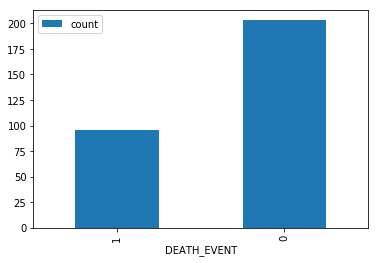

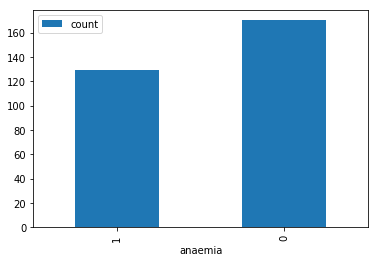

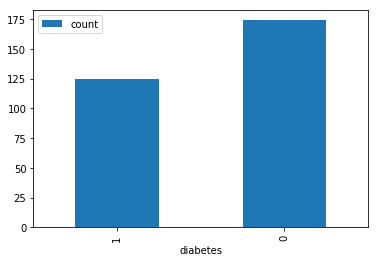

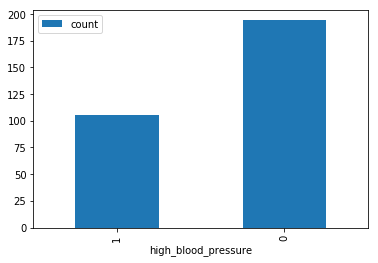

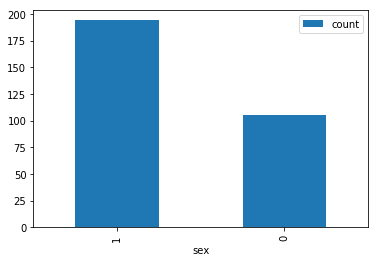

In [14]:
for column in categorical_columns:
    data.groupBy(column).count().toPandas().plot.bar(x=column, y='count')

imbalanced data for target variable

In [15]:
data.sort(data['creatinine_phosphokinase'].desc()).take(5)

[Row(age=55.0, anaemia=0, creatinine_phosphokinase=7861.0, diabetes=0, ejection_fraction=38.0, high_blood_pressure=0, platelets=263358.03125, serum_creatinine=1.100000023841858, serum_sodium=136.0, sex=1, smoking=0, time=6.0, DEATH_EVENT=1),
 Row(age=45.0, anaemia=0, creatinine_phosphokinase=7702.0, diabetes=1, ejection_fraction=25.0, high_blood_pressure=1, platelets=390000.0, serum_creatinine=1.0, serum_sodium=139.0, sex=1, smoking=0, time=60.0, DEATH_EVENT=1),
 Row(age=85.0, anaemia=0, creatinine_phosphokinase=5882.0, diabetes=0, ejection_fraction=35.0, high_blood_pressure=0, platelets=243000.0, serum_creatinine=1.0, serum_sodium=132.0, sex=1, smoking=1, time=72.0, DEATH_EVENT=1),
 Row(age=42.0, anaemia=0, creatinine_phosphokinase=5209.0, diabetes=0, ejection_fraction=30.0, high_blood_pressure=0, platelets=226000.0, serum_creatinine=1.0, serum_sodium=140.0, sex=1, smoking=1, time=87.0, DEATH_EVENT=0),
 Row(age=81.0, anaemia=0, creatinine_phosphokinase=4540.0, diabetes=0, ejection_fra

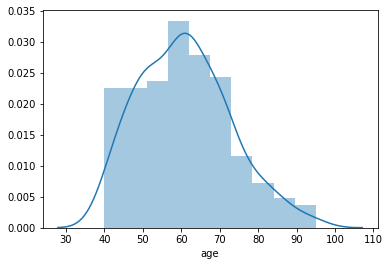

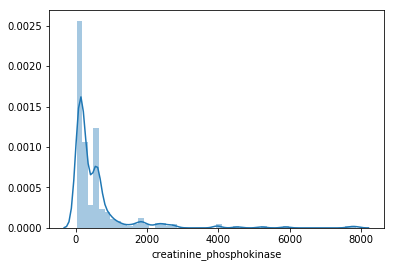

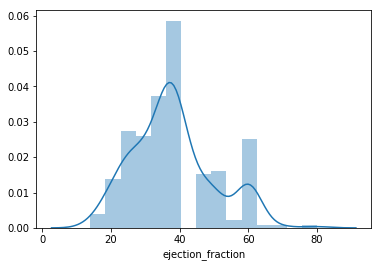

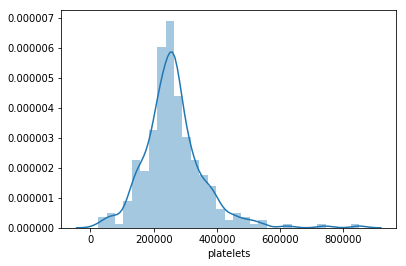

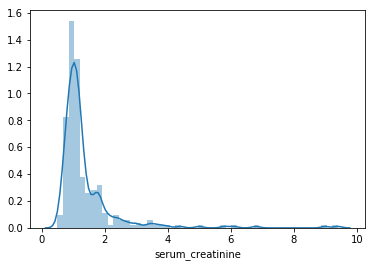

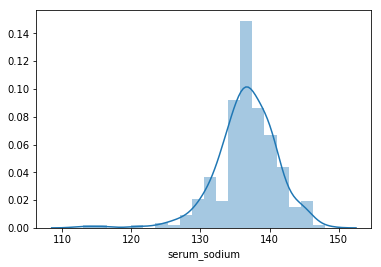

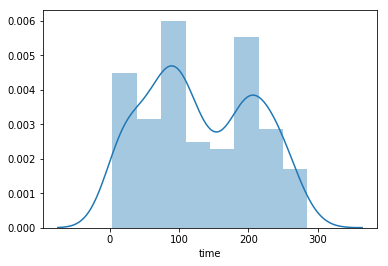

In [16]:
for column, dtype in data.dtypes:
    if dtype == 'float':
        sns.distplot(data.toPandas()[column])
        plt.show()

## Spark MLlib 

In [17]:
features = data.columns[:-1]
features

['age',
 'anaemia',
 'creatinine_phosphokinase',
 'diabetes',
 'ejection_fraction',
 'high_blood_pressure',
 'platelets',
 'serum_creatinine',
 'serum_sodium',
 'sex',
 'smoking',
 'time']

In [18]:
assembler = VectorAssembler(inputCols=features, outputCol="features")
assembler.transform(data).show(3)

+----+-------+------------------------+--------+-----------------+-------------------+---------+----------------+------------+---+-------+----+-----------+--------------------+
| age|anaemia|creatinine_phosphokinase|diabetes|ejection_fraction|high_blood_pressure|platelets|serum_creatinine|serum_sodium|sex|smoking|time|DEATH_EVENT|            features|
+----+-------+------------------------+--------+-----------------+-------------------+---------+----------------+------------+---+-------+----+-----------+--------------------+
|75.0|      0|                   582.0|       0|             20.0|                  1| 265000.0|             1.9|       130.0|  1|      0| 4.0|          1|[75.0,0.0,582.0,0...|
|55.0|      0|                  7861.0|       0|             38.0|                  0|263358.03|             1.1|       136.0|  1|      0| 6.0|          1|[55.0,0.0,7861.0,...|
|65.0|      0|                   146.0|       0|             20.0|                  0| 162000.0|             1.3|  

In [19]:
#the features don't need scaling because we are using decision trees
clf = DecisionTreeClassifier(featuresCol='features', labelCol='DEATH_EVENT')
pipeline = Pipeline(stages=[assembler, clf])
X_train, X_test = data.randomSplit([0.7, 0.3])

In [20]:
model = pipeline.fit(X_train)
pred = model.transform(X_test)

In [21]:
pred.select(pred['prediction'], pred['DEATH_EVENT']).show()

+----------+-----------+
|prediction|DEATH_EVENT|
+----------+-----------+
|       0.0|          0|
|       1.0|          0|
|       0.0|          0|
|       0.0|          0|
|       0.0|          0|
|       0.0|          0|
|       1.0|          1|
|       0.0|          1|
|       1.0|          1|
|       0.0|          0|
|       0.0|          1|
|       0.0|          0|
|       0.0|          1|
|       0.0|          1|
|       0.0|          0|
|       0.0|          1|
|       0.0|          0|
|       0.0|          0|
|       0.0|          1|
|       0.0|          0|
+----------+-----------+
only showing top 20 rows



In [22]:
evaluator = BinaryClassificationEvaluator(labelCol="DEATH_EVENT",
                                          rawPredictionCol="prediction",
                                          metricName='areaUnderROC')
#we use auc because of class imbalance
auc = evaluator.evaluate(pred)

print(f"the AUC score is {auc}")

the AUC score is 0.7834975369458127


In [23]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StandardScaler
columns_to_scale = ['age', 'creatinine_phosphokinase',
                    'ejection_fraction', 'platelets',
                    'serum_creatinine', 'serum_sodium','time']
assembler_cat = VectorAssembler(inputCols=categorical_columns, outputCol="categorical_features")
assembler_cont = VectorAssembler(inputCols=columns_to_scale, outputCol="continuous_features")
scaler = StandardScaler(inputCol='continuous_features', outputCol='continuous_scaled')
assembler2 = VectorAssembler(inputCols=['categorical_features', 'continuous_scaled'], outputCol='features')
clf2 = LogisticRegression(featuresCol='features', labelCol='DEATH_EVENT')
pipeline2 = Pipeline(stages=[assembler_cat, assembler_cont, scaler, assembler2, clf2])
model2 = pipeline2.fit(X_train)
pred2 = model2.transform(X_test)
auc2 = evaluator.evaluate(pred2)
print(f"the AUC score is {auc2}")

the AUC score is 0.9756157635467981


+ The score is quite good for decision tree, we can improve it by using RandomForest for example
+ the logistic regression has a very good score